# Word2Vec

In this notebook, you'll implement the **skip-gram** version of the Word2Vec model that was presented in the lecture. Please refer to the slides and to the original paper (https://arxiv.org/abs/1301.3781) whenever needed.

We'll use the WikiText2 dataset, which is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. 

To split the text into words, we shall use the 'basic_english' tokenizer from torchtext (https://pytorch.org/text/stable/index.html). This is a word-level tokenizer that splits a text into a list of English uncased words and punctuation symbols. Note that a special '\<unk>' token is used whenever an unknown word is found.

In [1]:
import numpy as np
import torch
from torchtext.datasets import WikiText2
from torchtext.data import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')

You should start by building `vocab`, a dictionary containing the vocabulary. The keys will be the words and the values are the corresponding indices, starting from 0. It is a good practice to discard rare words from the vocabulary, so we'll only keep those words that appear at least `MIN_REPS` times.

Thus, you should do the following in the cell below:

1. Build a `word_count` dictionary containing the number of times that each word appears. For this purpose, you should create an iterator from `train_iter` and iterate on it to get each sequence in the dataset. Each sequence should be split in a list of tokens (words) by calling the `tokenizer`. 

2. Build a `vocab` dictionary as described above. The `vocab` should only contain valid words that appear at least `MIN_REPS`. We have reserved a special index (-100) for the '\<unk>' token which you should use for out-of-vocabulary words.
    
It is also useful to have the inverse mapping from `vocab`, i.e. another dictionary that, given the word index, outputs the corresponding word. We have already built that for you in `vocab_inv`.

**Remark:** We could be using `torchtext.vocab`, which facilitates building the `vocab` dictionary and its inverse. For pedagogical reasons, this time you will implement these by yourself.

In [84]:
MIN_REPS = 50 

### YOUR CODE HERE ###
word_count = {}
for sequence in train_iter:
    tokens = tokenizer(sequence)
    for idx, tk in enumerate(tokens):
        if tk not in word_count:
            word_count[tk] = 1
        else:
            word_count[tk] += 1
vocab = {}
idx = 0
for tk, count in word_count.items():
    if count >= MIN_REPS and tk != "<unk>":
        vocab[tk] = idx
        idx += 1

### *** ###
vocab['<unk>'] = -100
vocab_inv = {val: key for (key, val) in vocab.items()}

print(f'Vocabulary has {len(vocab)-1} different words.')

Vocabulary has 4098 different words.


In [3]:
for i in range(10):
    print(vocab_inv.get(i, "KEY_ERROR"))

=
valkyria
chronicles
iii
no
3
(
japanese
,
.


Now it is time to complete the `SkipGramDataset` class by implementing its `__init__` method. This method receives `train_iter`, `vocab`, and the width of the window for the skip gram data. For each word, you will consider all the words that appear up to `window_width` words **before or after** the word, so the **total sequence length will be `2*window_width + 1`**.

In this `__init__` method you should build (input, context) pairs for the skip gram model and store them in the list attributes `self.inputs` and `self.contexts`.

In [4]:
class SkipGramDataset(Dataset):
    def __init__(self, train_iter, vocab, window_width):
        ### YOUR CODE HERE ###
        self.inputs = []
        self.contexts = []
        for sequence in train_iter:
            tokens = tokenizer(sequence)
            length = len(tokens)
            for i, tk in enumerate(tokens):
                if i < window_width or i >= length - window_width:
                    continue
                if tk not in vocab or tk == "<unk>":
                    continue
                for j in range(i - window_width, i + window_width + 1):
                    if j == i:
                        continue
                    next = tokens[j]
                    if next not in vocab or next == "<unk>":
                        continue
                    else:
                        self.inputs.append(vocab[tk])
                        self.contexts.append(vocab[next])
        ### *** ###
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.contexts[index]
        

In [5]:
WINDOW_WIDTH = 4

dataset = SkipGramDataset(train_iter, vocab, WINDOW_WIDTH)
print(f'Dataset has {len(dataset)} examples.')

Dataset has 10647430 examples.


In [6]:
count = 0
for input in dataset.inputs:
    if input < 0:
        count += 1

for context in dataset.contexts:
    if context < 0:
        count += 1

count

0

Let's look at some word pairs...

In [7]:
for i in range(200, 250):
    x, y = dataset[i]
    x_word = vocab_inv[x]
    y_word = vocab_inv[y]
    print(x_word, y_word)


by developed
by and
by media
by .
and game
and developed
and by
and media
and .
and vision
and for
media developed
media by
media and
media .
media vision
media for
media the
. by
. and
. media
. vision
. for
. the
. playstation
vision and
vision media
vision .
vision for
vision the
vision playstation
for and
for media
for .
for vision
for the
for playstation
for .
the media
the .
the vision
the for
the playstation
the .
the released
playstation .
playstation vision
playstation for
playstation the
playstation .


Let's implement the word2vec model. As you can see from the lecture slides, this model simply consists of an `nn.Embedding` layer mapping word indices to embeddings and a `nn.Linear` projection layer mapping to the vocabulary dimension. As you may already know, you should **not** apply the softmax at the output. The loss function you will use does that for you and in a more numerically stable way.

In [8]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_max_norm=None):
        super().__init__()
        ### YOUR CODE HERE ###
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      max_norm=embed_max_norm)
        self.linear = nn.Linear(in_features=embed_dim,
                                out_features=vocab_size)       
        ### *** ###
    
    def forward(self, x):
        '''
        Input:
          x: torch.LongTensor - tensor with shape (batch,) containing the indices of the input words
        Return value:
          logits: torch.FloatTensor - tensor with shape (batch, vocab_size) containing unnormalized probabilities
            for each word in the vocabulary
        '''
        ### YOUR CODE HERE ###
        embedded = self.embedding(x)
        logits = self.linear(embedded)
        ### *** ###
        return logits


Implement the `fit()` function in the cell below. This function should return two lists, containing the loss and accuracy values over the training epochs.

In [27]:
def fit(model, train_loader, optimizer, **kwargs):
    
    num_epochs = kwargs.get('num_epochs', 100)
    loss_fn = kwargs.get('loss_fn', nn.functional.cross_entropy)
    device = kwargs.get('device', torch.device('cpu'))
    
    model.train()
    train_loss_hist, train_acc_hist = [], []
    print("Entering training phase...")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        pbar = tqdm(train_loader, total=len(train_loader))
        train_loss, train_acc = 0, 0
        for x, y in pbar:
            ### YOUR CODE HERE ###
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                preds = logits.argmax(dim=1)
            acc = (preds == y).float().sum() / ((y != -100).float().sum() + 1e-6)
            ### *** ###
            train_loss += loss.item()
            train_acc += acc.item()
            pbar.set_description(f'loss = {loss:.3f} | acc = {acc:.3f}')

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'train loss = {train_loss:.3f} | train acc = {train_acc:.3f}')
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        
    return train_loss_hist, train_acc_hist

Now we instantiate the model, the optimizer and the dataloader and we're ready to train! As usual, we need to define a few hyperparameters. We set `EMBEDDING_DIM = 300` by default as this was the value used by the authors in the paper, but later you can play around with different values. Limiting the embeddings norm by setting `EMBEDDING_MAX_NORM = 1` is optional, but you can verify empirically that it will yield nicer embeddings. 

In [40]:
EMBEDDING_DIM = 300
EMBEDDING_MAX_NORM = 1
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print('DEVICE:', DEVICE)

model = SkipGramModel(vocab_size=len(vocab)-1, embed_dim=EMBEDDING_DIM,
                      embed_max_norm=EMBEDDING_MAX_NORM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

DEVICE: cuda


In [41]:
torch.version.cuda

'11.6'

In [42]:
next(model.parameters()).is_cuda

True

In [43]:
train_loss, train_acc = fit(model, dataloader, optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Entering training phase...
Epoch 0


loss = 6.673 | acc = 0.000: 100%|██████████| 83184/83184 [10:16<00:00, 134.95it/s]


train loss = 6.126 | train acc = 0.084
Epoch 1


loss = 5.255 | acc = 0.167: 100%|██████████| 83184/83184 [10:01<00:00, 138.22it/s]


train loss = 5.974 | train acc = 0.088
Epoch 2


loss = 5.984 | acc = 0.000: 100%|██████████| 83184/83184 [09:45<00:00, 142.14it/s]


train loss = 5.936 | train acc = 0.088
Epoch 3


loss = 7.313 | acc = 0.000: 100%|██████████| 83184/83184 [09:58<00:00, 139.10it/s]


train loss = 5.913 | train acc = 0.088
Epoch 4


loss = 5.137 | acc = 0.333: 100%|██████████| 83184/83184 [09:37<00:00, 144.13it/s]

train loss = 5.898 | train acc = 0.088


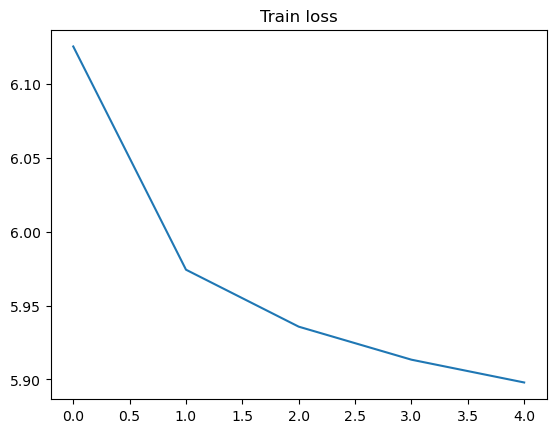

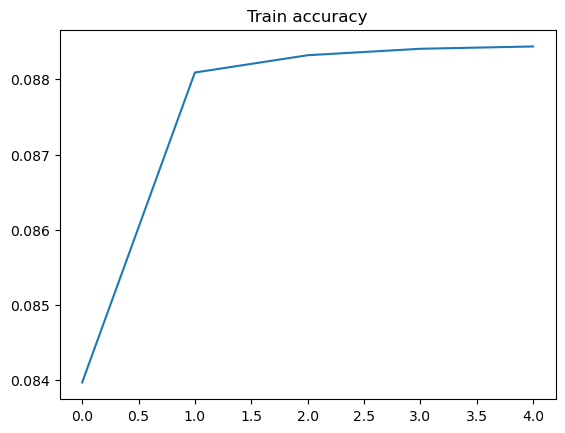

In [44]:
plt.title('Train loss')
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.title('Train accuracy')
plt.plot(range(len(train_acc)), train_acc)
plt.show()

In [45]:
torch.save(model.state_dict(), 'word2vec.pt')

Extract the embeddings from the model and normalize them to have unit L2-norm. Store the normalized embeddings in a `np.array` named `embeddings_norm`.

In [76]:
### YOUR CODE HERE ###
embeddings_norm = np.zeros((len(vocab) - 1, len(vocab) - 1))
for idx, token_idx in enumerate(vocab_inv):
    if token_idx < 0:
        continue
    token_idx = torch.tensor(token_idx).to(DEVICE)
    embedding = model(token_idx)
    embedding /= (embedding**2).sum().sqrt()
    embeddings_norm[idx] = embedding.detach().cpu().numpy()
### *** ###

Now we'll **visualize the learned embeddings**! Since these are 300-dimensional, they are impossible to visualize directly. First, **we need to project the embeddings into a two- (or three-)dimensional space**. We do this by using the t-Distributed Stochastic Neighbor Embedding algorithm (**t-SNE**, https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf), which usually provides very nice visualizations of high-dimensional data.

In [77]:
# get embeddings
embeddings_df = pd.DataFrame(embeddings_norm)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = [vocab_inv[i] for i in range(len(vocab_inv)-1)]

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()

C:\Users\Felipe\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\Felipe\anaconda3\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Run the cell below and open the generated file (word2vec_visualization.html) in your browser. Explore the embedding space. You should see semantically related words close to each other.

In [78]:
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("./word2vec_visualization.html")

Implement the function `get_most_similar`, which receives a `word` and outputs a dictionary where the keys are the `topN` words whose embeddings are closer (as measured by the cosine similarity) to the embedding of the `word`. The values of the returned dictionary should be filled with the similarities.

NOTE: What is a cosine similarity? 
It is [a measure for the similarity of two numerical sequences](https://en.wikipedia.org/wiki/Cosine_similarity), defined as:
$${\displaystyle {\text{cosine similarity}}=S_{C}(A,B):=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$$
However, since our embeddings have been $L^2$ normalized, this expression reduces to a simple dot product.

In [87]:
def get_most_similar(word, vocab, vocab_inv, embeddings, topN=1):
    ### YOUR CODE HERE ###
    if word not in vocab:
        raise ValueError("Out-of-vocabulary word")
        
    embedded_word = embeddings[vocab[word]] # Already normalized
    sim_measure = np.zeros(len(vocab) - 1)
    for idx, embed in enumerate(embeddings):
        # Compute cosine similarity
        cos_sim = embedded_word.dot(embed)
        sim_measure[idx] = cos_sim
    # Remove self-similarity
    sim_measure[vocab[word]] = 0.
    # Retrieve N most similar
    most_similar = np.argpartition(sim_measure, -topN)[-topN:]
    topN_dict = {vocab_inv[idx]: sim_measure[idx] for idx in most_similar}
    ## *** ###
    return topN_dict

In [89]:
for word in ['mother', 'portugal', 'queen', 'sports']:
    print(f"Top-10 words most similar to '{word}': {get_most_similar(word, vocab, vocab_inv, embeddings_norm, topN=10)}\n")

Top-10 words most similar to 'mother': {'marriage': 0.9939189618878457, 'childhood': 0.994191462906954, 'sister': 0.9944777641850377, 'husband': 0.998205339347774, 'father': 0.9985799521359424, 'daughter': 0.996377047892695, 'carol': 0.9959251962180061, 'wife': 0.9967699907666896, 'leslie': 0.9957421999576708, 'murder': 0.9949894109524331}

Top-10 words most similar to 'portugal': {'frelimo': 0.9925747314761783, 'overseas': 0.9927721249963637, 'conflict': 0.992817159036237, 'arrival': 0.992913178815407, 'jurchen': 0.9931085903008502, 'expedition': 0.9937993791004343, 'leadership': 0.9944367278622491, 'invasion': 0.9950541853516872, 'communist': 0.9943285752144269, 'administration': 0.9939862495269551}

Top-10 words most similar to 'queen': {'mary': 0.992428087948326, 'edward': 0.9925483531149006, 'louis': 0.9927012182354644, 'king': 0.9927668705894643, 'bishop': 0.9935678257254625, 'frank': 0.9934954013484225, 'frederick': 0.9947224080485901, 'iv': 0.9935612033469015, 'le': 0.994278013

## Negative sampling

Our vocabulary has only ~4k words, so training without negative sampling was doable. However, it is very common to have much larger vocabularies (10^5-10^7 words) where the original word2vec model is much more expensive to train.

For this reason, you'll now implement the skip-gram Word2Vec model with negative sampling. You should start by implementing a new dataset class in the cell below, which extends the original `SkipGramDataset`. The `SkipGramDatasetNS` should have the following attributes:
1. `inputs: List[int]` - same as before
2. `contexts: torch.LongTensor` - tensor with shape `(num_examples, num_neg + 1)` that contains the index of the positive word (true context) and the indices of the negative words, which are sampled from the vocabulary according to the distribution provided in the list `word_probs`. You can use the function `np.random.choice` to do the sampling.
3. `labels: torch.FloatTensor` - tensor with shape (num_neg + 1) that is 1 in the position corresponding to the positive word and 0 elsewhere.

**Remark:** We could be generating negative examples *on-the-fly* (i.e., in `__getitem__`) instead of generating them only once in `__init__`. This way we would avoid repeating the same negative examples every training epoch, which could improve the results a bit. However, `np.random.choice` is quite slow and therefore on-the-fly generation would slow down training considerably.

NOTE: We have not covered this topic in class since there wasn't enough time. However, I found a neat [reference](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/). I will try to complement this notebook with annotations about the principles of negative sampling as needed. [This one](https://analyticsindiamag.com/how-to-use-negative-sampling-with-word2vec-model/) is also great.

In [173]:
class SkipGramDatasetNS(SkipGramDataset):
    def __init__(self, train_iter, vocab, word_probs, window_width, num_neg):
        super().__init__(train_iter, vocab, window_width)
        ### YOUR CODE HERE ###
        train_iter = iter(train_iter)
        self.inputs = []
        pos_context = []
        # Keep track of number of valid examples (we skip OOV words)
        num_examples = 0
        # Pick input, context pairs as in regular SkipGram
        print("Generating skip-grams...")
        for sequence in train_iter:
            tokens = tokenizer(sequence)
            length = len(tokens)
            for i, tk in enumerate(tokens):
                if tk not in vocab or tk == "<unk>":
                    continue
                # Treat beginning and end of token sequence as special cases
                left_idx, right_idx = i - window_width, i + window_width + 1
                left_idx = 0 if i < window_width else left_idx
                right_idx = length if i > length - (window_width + 1) else right_idx
                for j in range(left_idx, right_idx):
                    if j == i:
                        continue
                    next = tokens[j]
                    if next not in vocab or next == "<unk>":
                        continue
                    else:
                        self.inputs.append(vocab[tk])
                        pos_context.append(vocab[next])
                        num_examples += 1
        print("Finished generating skip-grams.")
        self.contexts = torch.LongTensor(np.zeros((num_examples, num_neg + 1)))
        # Generate negative contexts
        rng = np.random.default_rng(seed=42)
        # Need to do it on a loop to avoid repeated words along last axis
        print("Generating negative samples...")
        neg_context = rng.choice(np.array(len(vocab) - 1), size=(num_examples, num_neg),
                                 replace=True, p=word_probs)
        self.contexts[:, 1:] = torch.from_numpy(neg_context)
        self.contexts[:, 0] = torch.tensor(pos_context)
        print("Finished generating negative samples.")
        # Mark position of positive context inside contexts LongTensor
        temp = np.zeros(num_neg + 1)
        temp[0] = 1
        self.labels = torch.tensor(temp)
        ### *** ###
    
    def __getitem__(self, index):
        '''
        Return values:
          input: int - the index of the input word 
          contexts: torch.LongTensor - tensor with shape (num_neg + 1,) containing the indices of the positive
            and negative words
          labels: torch.FloatTensor - tensor with binary labels with the same shape as contexts
        '''
        return self.inputs[index], self.contexts[index], self.labels

We can think of many distributions to sample our negatives from. The authors of wav2vec found empirically that a good option is to sample negative words $w$ from the distribution $q$ defined by: $$q(w) = \frac{\hat{p}(w)^{3/4}}{Z},$$ where $\hat{p}$ is the distribution of words in the training corpus and $Z$ is a normalization constant (such that $\sum_{\forall w \in V} q(w) = 1$). The fractional exponent (3/4) has a smoothing effect on the distribution, so that we avoid sampling the most frequent words too often.

In the cell below, build the list `word_probs` where `word_probs[i]`$= q(w_i)$.

In [174]:
### YOUR CODE HERE ###
word_count = {}
for sequence in train_iter:
    tokens = tokenizer(sequence)
    for idx, tk in enumerate(tokens):
        if tk not in vocab or tk == "<unk>":
            continue
        if tk not in word_count:
            word_count[tk] = 1
        else:
            word_count[tk] += 1
word_probs = np.array(list(word_count.values()), dtype="float64")
token_count = np.array(list(word_count.values())).sum()
word_probs /= token_count # Compute frequency of each token
word_probs = word_probs**0.75 # Increase probability of rare tokens
word_probs /= word_probs.sum() # Normalize

# Sanity check
print(word_probs.sum()) # should evaluate to 1
print(word_probs)
print(word_probs.size) 
print(len(vocab)) # +1 since includes <unk>
### *** ###

0.9999999999999999
[8.49302086e-03 7.50272480e-05 7.39827720e-05 ... 9.30942955e-05
 7.81321615e-05 7.91579780e-05]
4098
4099


Now we instantiate our dataset. We just need to decide the number of negative words to use. A small value (<10) is usually enough.

In [175]:
NUM_NEG = 5

datasetNS = SkipGramDatasetNS(train_iter, vocab, word_probs, WINDOW_WIDTH, NUM_NEG)
print(f'Dataset has {len(datasetNS)} examples.')

Generating skip-grams...
Finished generating skip-grams.
Generating negative samples...
Finished generating negative samples.
Dataset has 11339212 examples.


In [ ]:
# Draft code for forming SkipGrams correctly
tokens = ["i", "would", "like", "a", "cup",
          "of", "coffee", ",", "please"]
inputs = []
contexts = []
window_width = 2
length = len(tokens)
for i, tk in enumerate(tokens):
    # Treat beginning and end of token sequence as special cases
    left_idx, right_idx = i - window_width, i + window_width + 1
    left_idx = 0 if i < window_width else left_idx
    right_idx = length if i > length - (window_width + 1) else right_idx
    for j in range(left_idx, right_idx):
        if j == i:
            continue
        try:
            neighbour = tokens[j]
        except IndexError:
            print(j, length)
        inputs.append(tk)
        contexts.append(neighbour)
for i in range(len(inputs)):
    x, y = inputs[i], contexts[i]
    print(f"{x} {y}")

The model architecture and the `fit` routine also need to be changed. How? That's what you need to think about out now :)

In [203]:
class SkipGramModelNS(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_max_norm=None):
        super().__init__()
        ### YOUR CODE HERE ###
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      max_norm=embed_max_norm)
        self.linear = nn.Linear(in_features=embed_dim,
                                out_features=vocab_size)    
        self.vocab_size = vocab_size
        ### *** ###
    
    def forward(self, x, c):
        '''
        Inputs:
          x: torch.LongTensor - tensor with shape (batch,) containing the indices of the input words
          c: torch.LongTensor - tensor with shape (batch, num_context) containing the indices of the context words
        Return value:
          sim: torch.FloatTensor - tensor with shape (batch, num_context) containing the cosine similarities between
            the embeddings of x and the embeddings of each context word in c.
        '''
        ### YOUR CODE HERE ###
        batch_size, num_context = c.shape
        # Compute dense representation of input
        x_embed = self.embedding(x)
        x_out = self.linear(x_embed)
        # Compute dense representation of each context
        # and use it for similarity measure
        # Note that first measure corresponds to positive class
        # and the others to negative classes
        sim = torch.zeros((batch_size, num_context))
        for idx in range(num_context):
            c_embed = self.embedding(c[:, idx]) 
            c_out = self.linear(c_embed)
            # Store similarity measure with input representation
            # Trick to compute dot product over batch
            cosine_sim = torch.bmm(x_out.view(batch_size, 1, self.vocab_size),
                                   c_out.view(batch_size, self.vocab_size, 1)).squeeze()
            cosine_sim /= (c_out**2).sum(dim=1).sqrt()
            cosine_sim /= (x_out**2).sum(dim=1).sqrt()
            sim[:, idx] = cosine_sim            
        ### *** ###
        return sim


In [234]:
def fitNS(model, train_loader, optimizer, **kwargs):
    ### YOUR CODE HERE ###
    num_epochs = kwargs.get('num_epochs', 100)
    device = kwargs.get('device', torch.device('cpu'))
    def NSloss(output, target):
        pos_loss = -torch.log(torch.sigmoid(output[:, 0]))
        neg_loss = -(torch.log(1 - torch.sigmoid(output[:, 1:]))).sum(dim=1)
        loss = pos_loss + neg_loss
        return loss.mean()
    loss_fn = kwargs.get('loss_fn', NSloss)
    
    model.train() # Activate training mode
    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}')
        pbar = tqdm(train_loader, total=len(train_loader))
        train_loss, train_acc = 0, 0
        for x, c, y in pbar: # inputs, contexts, labels
            x, c, y = x.to(device), c.to(device), y.to(device)
            optimizer.zero_grad()
            sims = model(x, c)
            loss = loss_fn(sims, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                preds = sims.argmax(dim=1, keepdim=True).to(device)
            acc = (preds == y).float().sum() / ((y != -100).float().sum() + 1e-6)
            
            train_loss += loss.item()
            train_acc += acc.item()
            pbar.set_description(f'loss = {loss:.3f} | acc = {acc:.3f}')

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'train loss = {train_loss:.3f} | train acc = {train_acc:.3f}')
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
    ### *** ###
        
    return train_loss_hist, train_acc_hist

Now, we're ready to go! Due to negative sampling, this model should train a bit faster than the previous one.

In [237]:
print(DEVICE)

cuda


In [238]:
modelNS = SkipGramModelNS(vocab_size=len(vocab)-1, embed_dim=EMBEDDING_DIM, embed_max_norm=EMBEDDING_MAX_NORM).to(DEVICE)
optimizerNS = optim.Adam(modelNS.parameters(), lr=LEARNING_RATE)
dataloaderNS = DataLoader(datasetNS, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
train_lossNS, train_accNS = fitNS(modelNS, dataloaderNS, optimizerNS, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 0


loss = 4.161 | acc = 0.220:   1%|          | 569/88588 [00:17<41:19, 35.50it/s] 

In [ ]:
plt.title('Train loss (with neg. sampling)')
plt.plot(range(len(train_lossNS)), train_lossNS)
plt.show()
plt.title('Train accuracy (with neg. sampling)')
plt.plot(range(len(train_accNS)), train_accNS)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'word2vecNS.pt')

Now we repeat the experiments we have done before for the model without negative sampling. You can copy the code for normalizing the embeddings and paste it in the cell below.

In [ ]:
### YOUR CODE HERE ###

### *** ###

In [ ]:
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = [vocab_inv[i] for i in range(len(vocab_inv)-1)]

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()

In [ ]:
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html("./word2vecNS_visualization.html")

In [ ]:
for word in ['mother', 'portugal', 'queen', 'sports']:
    print(f"Top-10 words most similar to '{word}': {get_most_similar(word, vocab, vocab_inv, embeddings_norm, topN=10)}")

## Playground

Now you can have some fun finding other interesting relations in the embeddings you have learned. There are also a few hyperparameters that we have defined rather arbitrarily that you can play with.
With little effort, you can also implement the **continuous bag-of-words (CBOW)** version of Word2Vec.